# 我们将训练来自18种起源语言的数千种姓氏，并根据拼写来预测名称的来源

准备数据完毕！！！！
现在，我们有了category_lines字典，将每个类别（语言）映射到行（名称）列表。我们还跟踪了 all_categories（只是一种语言列表），n_categories供以后参考。

In [2]:

from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)
print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
print(n_letters)


# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
# 转为ASCII编码
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print(n_categories)  # 18个类标签

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']
57
Slusarski
18


In [3]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


# 将名称转换为张量

In [4]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))  # J的one-hot向量

print(lineToTensor('Jones').size())  # Jones这个词的张量
print(lineToTensor('Joness').size())  # Jones这个词的张量


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])
torch.Size([6, 1, 57])


# 建立网络

In [30]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)# 57+128, 128
        self.i2o = nn.Linear(input_size + hidden_size, output_size)# 57+128, 18
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)  # 57+128, 128
        output = self.i2o(combined)  # 57+128, 18
        output = self.softmax(output)
        return output, hidden  # 返回
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)  # 输入， 隐层， 类    57维的one-hot向量， 128， 18个类标签
print(rnn, n_letters, n_hidden, n_categories)

RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): LogSoftmax()
) 57 128 18


In [29]:
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [32]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output.shape, output)

torch.Size([1, 18]) tensor([[-2.8616, -2.8874, -2.9652, -2.9233, -2.8242, -2.9419, -2.8551, -2.9061,
         -2.7922, -2.8703, -2.9369, -2.9246, -2.8865, -2.8254, -2.8455, -2.9542,
         -2.9372, -2.9101]], grad_fn=<LogSoftmaxBackward>)


In [33]:
# 获取概率最大的类
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))


('Irish', 8)


In [34]:
# 快速的方法来获取培训示例
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Dutch / line = Sneijders
category = Arabic / line = Gerges
category = Scottish / line = Williamson
category = Vietnamese / line = Nguyen
category = Portuguese / line = Pereira
category = Chinese / line = Qin
category = Japanese / line = Takahama
category = Japanese / line = Nishi
category = Japanese / line = Matsushita
category = Arabic / line = Maalouf


In [40]:
criterion = nn.NLLLoss()
learning_rate = 0.005

每个培训循环将：

创建输入和目标张量
创建归零的初始隐藏状态
阅读和中的每个字母
保持下一个字母的隐藏状态
比较最终输出与目标
反向传播
返回输出和损失

In [38]:
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()


In [41]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 13s) 2.8604 Suaird / Arabic ✗ (Irish)
10000 10% (0m 24s) 1.6651 Tong / Chinese ✗ (Vietnamese)
15000 15% (0m 35s) 2.1231 Savchak / Arabic ✗ (Czech)
20000 20% (0m 45s) 3.8679 Jez / Chinese ✗ (Polish)
25000 25% (0m 56s) 0.7103 Yun / Chinese ✓
30000 30% (1m 7s) 1.4253 Aggelen / Dutch ✓
35000 35% (1m 18s) 1.6448 De campo / Portuguese ✗ (Italian)
40000 40% (1m 28s) 0.3558 Demakis / Greek ✓
45000 45% (1m 39s) 0.9428 Brivio / Italian ✓
50000 50% (1m 50s) 2.0796 Amadei / Polish ✗ (Italian)
55000 55% (2m 2s) 3.5969 Aloia / Arabic ✗ (Italian)
60000 60% (2m 13s) 2.6100 Lyme / Korean ✗ (English)
65000 65% (2m 24s) 1.2628 Janosik / Polish ✗ (Czech)
70000 70% (2m 36s) 1.2558 Gok / Korean ✗ (Chinese)
75000 75% (2m 47s) 2.1910 Machado / Japanese ✗ (Portuguese)
80000 80% (2m 59s) 1.7237 Yong / Korean ✗ (Chinese)
85000 85% (3m 11s) 3.2273 Sechnall / Czech ✗ (Irish)
90000 90% (3m 23s) 2.0175 Halliday / Czech ✗ (English)
95000 95% (3m 34s) 0.2941 Tong / Vietnamese ✓
100000 100% (3m 45s) 1.1846 

In [42]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

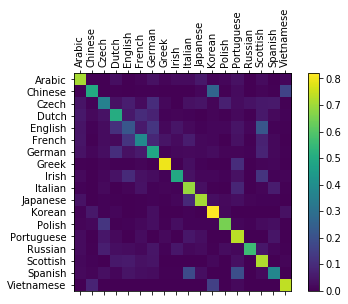

In [43]:
# 评估
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [44]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-1.05) Russian
(-1.09) Czech
(-1.62) English

> Jackson
(-0.05) Scottish
(-3.39) English
(-5.40) Dutch

> Satoshi
(-1.14) Japanese
(-1.20) Italian
(-2.71) Polish
